# Sixth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [1]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader


def evaluate_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return(accuracy)

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [2]:
from collections import OrderedDict

class Flatten(nn.Module):
    """ Flatten feature dimension to (batch_size, feature_dim, 1).
            
        Note: This layer doesn't exist in pytorch but allows us to create
              the model using `Sequential` only.
    """       
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input_cache = x.shape
        batch_size = x.shape[0]
        flat = x.reshape(batch_size, -1)
        #print(x.shape)
        #print(flat.shape)
        return flat
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        old_shape = self.input_cache
        return grad.reshape(old_shape)

def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=1)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    
    # START ################
        
    d = OrderedDict([
        ('conv0', nn.Conv2d(in_channels=1, out_channels= num_filters_per_layer[0], kernel_size=conv_kernel_size, stride=1, padding=0)),
        ('relu0', nn.ReLU()),
        ('maxpool0', nn.MaxPool2d(kernel_size=pool_kernel_size, stride=1))
    ])
    
    out_conv = (28 - conv_kernel_size ) + 1
    out_max = (out_conv - pool_kernel_size) + 1
    
    for l in range(1, len(num_filters_per_layer)):
        d['conv' + str(l)] = nn.Conv2d(in_channels=num_filters_per_layer[l-1], out_channels=num_filters_per_layer[l], kernel_size=conv_kernel_size, stride=1, padding=0)
        d['relu' + str(l)] = nn.ReLU()
        d['maxpool' + str(l)] = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=1)
        out_conv = (out_max - conv_kernel_size ) + 1
        out_max = (out_conv - pool_kernel_size) + 1
    
    #print(out_conv, out_max)
    
    d['flatten'] = Flatten()
    d['linear'] =  nn.Linear(num_filters_per_layer[-1] * out_max * out_max, 10)
    d['logsoftmax'] = nn.LogSoftmax(dim=1)
    
    conv = nn.Sequential(d)  
    
    return conv
    
    
    # End ################


def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START ################
    
    # learning rate
    lr = CSH.UniformFloatHyperparameter('learning_rate', lower=1e-6, upper=1e-0, log=True)
    # num_filters_1
    num_filters_1 = CSH.UniformIntegerHyperparameter('num_filters_1', lower=2, upper=8)
    # num_filters_2
    num_filters_2 = CSH.UniformIntegerHyperparameter('num_filters_2', lower=2, upper=8)
    # num_conv_layers
    num_conv_layers = CSH.UniformIntegerHyperparameter('num_conv_layers', lower=1, upper=2)
    #condition
    cond = CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1)
    
    cs.add_hyperparameters([lr, num_filters_1, num_filters_2, num_conv_layers])
    cs.add_condition(cond)
    
    # End ################
    return cs

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [3]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START ################
    # retrieve the number of filters from the config and create the model
    num_filter = []
    
    num_filter.append(config['num_filters_1'])
    
    if config['num_conv_layers'] > 1:
        num_filter.append(config['num_filters_2'])
        
    model = get_conv_model(num_filter)
      
    # define loss and optimizer
    lr = config['learning_rate']
    
    loss = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    
    
    # train the model for `epochs` and save the validation error for each epoch in
    # val_errors
    
    val_errors = []
    
    for e in range(epochs):
        model.train()
        
        for b in train_loader: 
            optimizer.zero_grad()
            loss(model(b[0]), b[1]).backward()
            optimizer.step()

        val_errors.append(1 - evaluate_accuracy(model, validation_loader))

    # End ################
    return model, val_errors

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [93]:
n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

# START ################
#print(cs.sample_configuration())
#run_conv_model(cs.sample_configuration(), n_epochs, train_loader, validation_loader)

results = []

for samp in range(n_random_samples):
    conf = cs.sample_configuration()
    model, val_errors = run_conv_model(conf, n_epochs, train_loader, validation_loader)
    results.append((model, conf, val_errors))
    
    print(str(samp) + ': ', conf)


# End ################

0:  Configuration:
  learning_rate, Value: 0.0013784083510808768
  num_conv_layers, Value: 2
  num_filters_1, Value: 2
  num_filters_2, Value: 2

1:  Configuration:
  learning_rate, Value: 1.3390197874151765e-06
  num_conv_layers, Value: 1
  num_filters_1, Value: 4

2:  Configuration:
  learning_rate, Value: 0.00010885595317412895
  num_conv_layers, Value: 2
  num_filters_1, Value: 2
  num_filters_2, Value: 3

3:  Configuration:
  learning_rate, Value: 0.0008727881029078696
  num_conv_layers, Value: 2
  num_filters_1, Value: 6
  num_filters_2, Value: 4

4:  Configuration:
  learning_rate, Value: 2.7467194799668092e-05
  num_conv_layers, Value: 2
  num_filters_1, Value: 3
  num_filters_2, Value: 6

5:  Configuration:
  learning_rate, Value: 1.6874651405361605e-05
  num_conv_layers, Value: 2
  num_filters_1, Value: 2
  num_filters_2, Value: 6

6:  Configuration:
  learning_rate, Value: 1.7584261911672624e-05
  num_conv_layers, Value: 1
  num_filters_1, Value: 6

7:  Configuration:
  lear

### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [94]:
# START ################
last_error_list = [x[2][-1] for x in results]
min_error_index = last_error.index(min(last_error))
best_model = results[min_error_index]

print('Model:\n', best_model[0])
print(best_model[1]) # configuration
print('Validation error:\n', best_model[2][-1]) # final error
# END ################

Model:
 Sequential(
  (conv0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
  (relu0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(7, 5, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear): Linear(in_features=2420, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)
Configuration:
  learning_rate, Value: 0.02822524857170984
  num_conv_layers, Value: 2
  num_filters_1, Value: 7
  num_filters_2, Value: 5

Validation error:
 0.04296875


Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

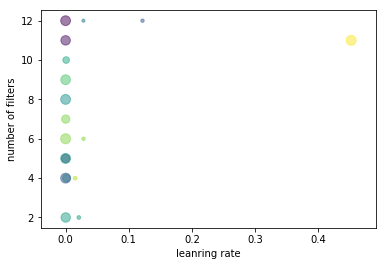

In [95]:
# START ################

# learning rate for x
x = [x[1]['learning_rate'] for x in results]

# sum of num filters over layers for y
sum_num_filter = []

confs = [x[1] for x in results]

for conf in confs:
    sum_filter = conf['num_filters_1']
    if 'num_filters_2' in conf.keys():
        sum_filter += conf['num_filters_2'] 
        
    sum_num_filter.append(sum_filter)

y = sum_num_filter

colors = np.random.rand(len(results))

# scale size of scatter points
last_error_list = [x[2][-1] for x in results]

OldMin = min(last_error_list)
OldMax = max(last_error_list)
NewMin = 10
NewMax = 100

new_last_error_list = []

for err in last_error_list:
    new_last_error_list.append((((err - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin)

#print(last_error_list)
#print(new_last_error_list)    

plt.xlabel("leanring rate")
plt.ylabel("number of filters")

plt.scatter(x, y, s=new_last_error_list, c=colors, alpha=0.5)

plt.show()


# END ################

**Question:** What pattern do you see? Why might it occur?

**Answer:** **TODO** The most learning rates are located around zero. The most configurtions have high error rates (larger circles).

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

<function matplotlib.pyplot.show>

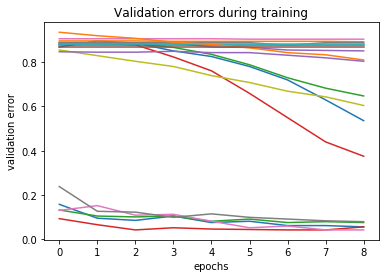

In [96]:
# START ################
error_curves = [x[2] for x in results]

x = range(len(error_curves))

for curve in error_curves:
    plt.plot(curve)

plt.title('Validation errors during training')
plt.xlabel("epochs")
plt.ylabel("validation error")
plt.show

# END ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:** We could define a threshold. When the error is greater than this value we could stop with this configuration and continue with the next one. But it could be possible that the error increase/decrease later which we wouldn' notice with an early stop.

### Your Feedback on Exercise 6.1

We invested about 6h. We had problems with the get_conv_model function where we didn't know what input size the Linear layer has and how we do the flatten operation before this layer. But it was good to think about this stuff.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [4]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

C:\Users\Megan\Anaconda3\lib\site-packages\Pyro4\util.py:839: UserWarning: msgpack serializer unavailable. requires msgpack 0.5.2+, found (0, 5, 1)
  warnings.warn("msgpack serializer unavailable. requires msgpack 0.5.2+, found " + str(msgpack.version))
C:\Users\Megan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [5]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START ################
        assert config['num_conv_layers'] > 0, "num_conv_layers should be greater than 0"
        pool_kernel_size = 2
        conv_kernel_size = 3

        # get num_filters
        num_filters_per_layer = []
        for key in config.keys():
            if key.startswith('num_filters'):
                #print('key -> get_model', key)
                num_filters_per_layer.append(config[key])
        
        
        d = OrderedDict([
            ('conv0', nn.Conv2d(in_channels=1, out_channels= num_filters_per_layer[0], kernel_size=conv_kernel_size, stride=1, padding=0)),
            ('relu0', nn.ReLU()),
            ('maxpool0', nn.MaxPool2d(kernel_size=pool_kernel_size, stride=1))
        ])

        out_conv = (28 - conv_kernel_size ) + 1
        out_max = (out_conv - pool_kernel_size) + 1

        for l in range(1, len(num_filters_per_layer)):
            d['conv' + str(l)] = nn.Conv2d(in_channels=num_filters_per_layer[l-1], out_channels=num_filters_per_layer[l], kernel_size=conv_kernel_size, stride=1, padding=0)
            d['relu' + str(l)] = nn.ReLU()
            d['maxpool' + str(l)] = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=1)
            out_conv = (out_max - conv_kernel_size ) + 1
            out_max = (out_conv - pool_kernel_size) + 1

        #print(out_conv, out_max)

        d['flatten'] = Flatten()
        d['linear'] =  nn.Linear(num_filters_per_layer[-1] * out_max * out_max, 10)
        d['logsoftmax'] = nn.LogSoftmax(dim=1)

        conv = nn.Sequential(d)  

        return conv

        # END ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START ################
        cs = CS.ConfigurationSpace()
        
        # num_filters_1
        num_filters_1 = CSH.UniformIntegerHyperparameter('num_filters_1', lower=4, upper=32)
        # num_filters_2
        num_filters_2 = CSH.UniformIntegerHyperparameter('num_filters_2', lower=4, upper=32)
        # num_filters_3
        num_filters_3 = CSH.UniformIntegerHyperparameter('num_filters_3', lower=4, upper=32)
        # num_conv_layers
        num_conv_layers = CSH.UniformIntegerHyperparameter('num_conv_layers', lower=1, upper=3)

        # learning rate
        lr = CSH.UniformFloatHyperparameter('learning_rate', lower=1e-6, upper=1e-1, log=True)
        # sgd momentum
        sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.00, upper=0.99)
        #optimizer
        optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])
        
        #condition
        cond1 = CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1)
        cond2 = CS.GreaterThanCondition(num_filters_3, num_conv_layers, 2)
        cond3 = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')

        cs.add_hyperparameters([num_filters_1, num_filters_2, num_filters_3, num_conv_layers, lr, sgd_momentum, optimizer])
        cs.add_conditions([cond1, cond2, cond3])

        return cs
  
        # END ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> float:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        # START ################
        
        # define loss and optimizer
        lr = config['learning_rate']
        
        loss = nn.NLLLoss()
        
        if config['optimizer'] == 'Adam':
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        else:
            momentum = config['sgd_momentum']
            optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

        # train the model for `budget` 
        
        for e in range(int(budget)):
            model.train()

            for b in self.train_loader: 
                optimizer.zero_grad()
                loss(model(b[0]), b[1]).backward()
                optimizer.step()    

        # END ################
        
        train_accuracy = evaluate_accuracy(model, self.train_loader)
        validation_accuracy = evaluate_accuracy(model, self.validation_loader)
        test_accuracy = evaluate_accuracy(model, self.test_loader)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [6]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [7]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'learning_rate': 0.021190471713116728, 'num_conv_layers': 1, 'num_filters_1': 23, 'optimizer': 'Adam'}
{'loss': 0.0546875, 'info': {'test_accuracy': 0.9324, 'train_accuracy': 0.966064453125, 'valid_accuracy': 0.9453125, 'model': 'Sequential(\n  (conv0): Conv2d(1, 23, kernel_size=(3, 3), stride=(1, 1))\n  (relu0): ReLU()\n  (maxpool0): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)\n  (flatten): Flatten()\n  (linear): Linear(in_features=14375, out_features=10, bias=True)\n  (logsoftmax): LogSoftmax()\n)'}}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [8]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [ ]:
try:
    # Start a nameserver
    #host = hpns.nic_name_to_host(nic_name)
    host = '127.0.0.1'
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)
    
    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

### Evaluate result

The result object which we dumped to disk contains all the runs with the different configurations.
Here we will analyse it further. The [HpBandSter Analysis Example](https://automl.github.io/HpBandSter/build/html/auto_examples/plot_example_6_analysis.html) is there, if you need help.

In [ ]:
#  load a saved result object if necessary
with open(result_file, 'rb') as f:
    result = pickle.load(f)

**Task:** Print the model of the best run, evaluated on the largest budget, with it's final validation error. *Tipp:* Have a look at the [HpBandSter Result Docs](https://automl.github.io/HpBandSter/build/html/core/result.html).

In [ ]:
# START TODO ################

# END TODO ################

We can gain deeper insight through plotting results. Thanks to the [HpBandSter Visualization Module](https://automl.github.io/HpBandSter/build/html/core/visualization.html) plotting is a one-liner.

In [ ]:
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

First let's see, if we really can evaluate more configurations when makeing use of low budget runs.

**Task:** Plot the finished runs over time. How many runs per minute did finish for the individual budgets (only approximately)? 

**Answer:** **TODO** 

In [ ]:
# START TODO ##################


Evaluating configurations on lower budgets doesn't make sense - even if they are faster - if the performance ranking isn't consistent from low to high budget. This means, that the loss rankings for configurations should correlate. In simplified terms: The best configuration after one epoch should also be the best after nine epochs, the second best should stay the second best and so on.

**Task:** Plot correlations of rankings across budgets. Are the correlations high enough?

**Answer:** **TODO** 

In [ ]:
# START TODO ##################


We usually assume, that training on a higher budget (number of epochs) and sampling more configurations can lead to better results. Let's check this.

**Task:** Plot the losses over time. Do our assumptions hold true? Why?

**Answer:** **TODO**    

In [ ]:
# START TODO ##################


Remember that BOHB uses a model after some time to improve the configuation sampling. We can check, if the BO-sampled configurations work better than the random-sampled.

**Task:** Plot loss histograms for all budgets only with BO-sampled and only with random-sampled configurations (6 histograms). Is the BO-sampling useful?

**Answer:** **TODO**

In [ ]:
# START TODO ##################


### Your Feedback on Exercise 6.2
